In [1]:
import os
import glob
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, DataLoader

from eye_tracker_dataset import EyeTrackerDataset

In [2]:
class EyeTrackerNet(nn.Module) :
    def __init__(self) :
        super(EyeTrackerNet, self).__init__()

        self.fc1 = nn.Linear(81 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 8)
        self.fc6 = nn.Linear(8, 2)

    def forward(self, x) :
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)
        x = self.fc5(x)
        x = F.relu(x)
        x = self.fc6(x)
        x = F.relu(x)
        return x

CKPT_PATH = "./checkpoints/model_20230428_105603_199"

model = EyeTrackerNet()
model.load_state_dict(torch.load(
    CKPT_PATH
))

<All keys matched successfully>

In [3]:
eye_tracker_dataset = EyeTrackerDataset()

torch_generator = torch.Generator().manual_seed(42)
train_dataset, test_dataset = random_split(eye_tracker_dataset, [0.7, 0.3], generator=torch_generator)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
test_loader  = DataLoader(test_dataset,  batch_size = 64, shuffle = True)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(
    params = model.parameters(),
    lr = 0.0001
)

In [4]:
def train_one_epoch(train_loader):
    loss_accumulated = 0
    n_data_accumulated = 0

    with tqdm(
        total = len(train_loader),
        desc = "train"
    ) as inner_pbar :
        for i, data in enumerate(train_loader):
            inputs = torch.cat(
                [
                    data["face_oval_landmark_array"],
                    data["left_eye_landmark_array"],
                    data["left_iris_landmark_array"],
                    data["right_eye_landmark_array"],
                    data["right_iris_landmark_array"]
                ],
                dim=1
            )
            n_data = inputs.shape[0]
            inputs = inputs.view(n_data, -1)
            labels = data["mouse_position"]


            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            curr_loss  = loss.item()
            loss_accumulated += loss.item() * n_data
            n_data_accumulated += n_data
            whole_mean_loss = loss_accumulated / n_data_accumulated

            inner_pbar.update(1)
            inner_pbar.set_postfix_str(curr_loss)
            
    return whole_mean_loss

def valid_one_epoch(valid_loader) :
    loss_accumulated = 0
    n_data_accumulated = 0

    with tqdm(
        total = len(valid_loader),
        desc = "valid"
    ) as inner_pbar :
        for i, data in enumerate(valid_loader):
            inputs = torch.cat(
                [
                    data["face_oval_landmark_array"],
                    data["left_eye_landmark_array"],
                    data["left_iris_landmark_array"],
                    data["right_eye_landmark_array"],
                    data["right_iris_landmark_arrya"]
                ],
                dim=1
            )
            n_data = inputs.shape[0]
            inputs = inputs.view(n_data, -1)
            labels = data["mouse_position"]

            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            curr_loss  = loss.item()
            loss_accumulated += loss.item() * n_data
            n_data_accumulated += n_data
            whole_mean_loss = loss_accumulated / n_data_accumulated

            inner_pbar.update(1)
            inner_pbar.set_postfix_str(curr_loss)
            
    return whole_mean_loss

In [5]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
N_MODEL_TO_SAVE = 3

model_dict_list = []
train_loss_list = []
valid_loss_list = []
train_valid_loop_cache = [{"valid_loss":100}]

curr_epoch_idx = 0

In [ ]:
curr_epoch_idx

  0%|          | 0/200 [00:00<?, ?it/s]

train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.06525 vloss : 0.06176


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.06124 vloss : 0.06180


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.06072 vloss : 0.06113


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.06031 vloss : 0.06027


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05988 vloss : 0.05999


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05961 vloss : 0.05963


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05932 vloss : 0.05940


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05914 vloss : 0.05912


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05900 vloss : 0.05903


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05886 vloss : 0.05867


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05859 vloss : 0.05854


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05851 vloss : 0.05844


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05837 vloss : 0.05829


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05835 vloss : 0.05834


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05812 vloss : 0.05816


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05778 vloss : 0.05844


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05767 vloss : 0.05844


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05770 vloss : 0.05774


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05764 vloss : 0.05880


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05739 vloss : 0.05751


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05727 vloss : 0.05735


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05740 vloss : 0.05733


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05702 vloss : 0.05748


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05717 vloss : 0.05728


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05701 vloss : 0.05810


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05701 vloss : 0.05698


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05666 vloss : 0.05755


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05679 vloss : 0.05758


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05682 vloss : 0.05991


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05667 vloss : 0.05748


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05660 vloss : 0.05742


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05645 vloss : 0.05651


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05622 vloss : 0.05709


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05610 vloss : 0.05648


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05602 vloss : 0.05634


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05591 vloss : 0.05660


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05603 vloss : 0.05633


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05592 vloss : 0.05648


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05601 vloss : 0.05620


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05639 vloss : 0.05665


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05576 vloss : 0.05633


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05557 vloss : 0.05757


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05569 vloss : 0.05625


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05554 vloss : 0.05567


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05538 vloss : 0.05566


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05523 vloss : 0.05581


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05540 vloss : 0.05577


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05525 vloss : 0.05562


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05532 vloss : 0.05554


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05501 vloss : 0.05571


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05509 vloss : 0.05534


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05511 vloss : 0.05542


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05514 vloss : 0.05538


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05495 vloss : 0.05520


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05484 vloss : 0.05532


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05473 vloss : 0.05518


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05461 vloss : 0.05510


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05508 vloss : 0.05522


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05445 vloss : 0.05552


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05442 vloss : 0.05492


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05439 vloss : 0.05547


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05440 vloss : 0.05526


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05476 vloss : 0.05467


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05432 vloss : 0.05459


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05405 vloss : 0.05541


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05412 vloss : 0.05492


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05431 vloss : 0.05462


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05401 vloss : 0.05437


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05380 vloss : 0.05494


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05404 vloss : 0.05415


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05409 vloss : 0.05467


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05375 vloss : 0.05408


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05369 vloss : 0.05420


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05381 vloss : 0.05431


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05363 vloss : 0.05412


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05387 vloss : 0.05561


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05380 vloss : 0.05438


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05354 vloss : 0.05413


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05345 vloss : 0.05378


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05335 vloss : 0.05408


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05341 vloss : 0.05367


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05360 vloss : 0.05375


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05348 vloss : 0.05366


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05331 vloss : 0.05408


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05313 vloss : 0.05392


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05320 vloss : 0.05397


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05309 vloss : 0.05397


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05315 vloss : 0.05336


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05309 vloss : 0.05337


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05322 vloss : 0.05367


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05294 vloss : 0.05469


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05266 vloss : 0.05477


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05280 vloss : 0.05356


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05296 vloss : 0.05323


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05281 vloss : 0.05314


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05274 vloss : 0.05319


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05257 vloss : 0.05395


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05259 vloss : 0.05323


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05230 vloss : 0.05306


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05242 vloss : 0.05313


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05223 vloss : 0.05302


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05225 vloss : 0.05267


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05224 vloss : 0.05325


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05214 vloss : 0.05259


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05213 vloss : 0.05279


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05186 vloss : 0.05280


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05203 vloss : 0.05311


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05195 vloss : 0.05276


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05201 vloss : 0.05281


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05188 vloss : 0.05235


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05183 vloss : 0.05231


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05165 vloss : 0.05270


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05174 vloss : 0.05253


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05161 vloss : 0.05342


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05146 vloss : 0.05270


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05151 vloss : 0.05242


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05130 vloss : 0.05220


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05128 vloss : 0.05190


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05125 vloss : 0.05264


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05123 vloss : 0.05186


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05120 vloss : 0.05183


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05121 vloss : 0.05248


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05111 vloss : 0.05173


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05098 vloss : 0.05192


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05131 vloss : 0.05149


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05095 vloss : 0.05263


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05103 vloss : 0.05279


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05110 vloss : 0.05197


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05089 vloss : 0.05145


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05058 vloss : 0.05191


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05070 vloss : 0.05147


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05077 vloss : 0.05148


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05059 vloss : 0.05182


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05049 vloss : 0.05195


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05038 vloss : 0.05177


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05074 vloss : 0.05112


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05030 vloss : 0.05213


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05062 vloss : 0.05116


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05046 vloss : 0.05115


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05045 vloss : 0.05139


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05001 vloss : 0.05152


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05012 vloss : 0.05147


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04989 vloss : 0.05054


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05032 vloss : 0.05084


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05009 vloss : 0.05060


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.05021 vloss : 0.05071


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04978 vloss : 0.05055


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04962 vloss : 0.05035


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04956 vloss : 0.05042


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04967 vloss : 0.05042


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04986 vloss : 0.05120


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04940 vloss : 0.05035


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04951 vloss : 0.05102


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04958 vloss : 0.05036


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04950 vloss : 0.05043


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04950 vloss : 0.05011


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04915 vloss : 0.05082


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04922 vloss : 0.05112


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04941 vloss : 0.05023


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04910 vloss : 0.05013


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04935 vloss : 0.05027


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04941 vloss : 0.04983


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04932 vloss : 0.05020


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04882 vloss : 0.04996


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04896 vloss : 0.04975


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04897 vloss : 0.05064


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04891 vloss : 0.05011


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04897 vloss : 0.05009


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04904 vloss : 0.04976


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04866 vloss : 0.04965


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04878 vloss : 0.04960


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04843 vloss : 0.04927


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04881 vloss : 0.05023


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04880 vloss : 0.05009


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04851 vloss : 0.04999


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04814 vloss : 0.04905


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04820 vloss : 0.04933


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04836 vloss : 0.04904


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04815 vloss : 0.04907


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04828 vloss : 0.04913


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04832 vloss : 0.04908


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04803 vloss : 0.04998


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04811 vloss : 0.04876


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04814 vloss : 0.04901


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04793 vloss : 0.04895


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04798 vloss : 0.04898


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04784 vloss : 0.05082


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04852 vloss : 0.04980


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04767 vloss : 0.04941


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04781 vloss : 0.04905


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04799 vloss : 0.04828


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04756 vloss : 0.04883


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04745 vloss : 0.04851


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04726 vloss : 0.04949


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04728 vloss : 0.04890


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04760 vloss : 0.05037


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04711 vloss : 0.04890


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04714 vloss : 0.04899


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04728 vloss : 0.04824


train:   0%|          | 0/101 [00:00<?, ?it/s]

valid:   0%|          | 0/43 [00:00<?, ?it/s]

tloss : 0.04725 vloss : 0.04973


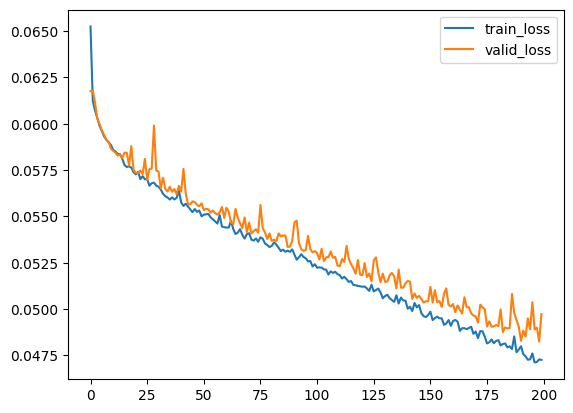

In [6]:
N_EPOCHS = 200

with tqdm(total=N_EPOCHS) as outer_pbar :
    for epoch in range(curr_epoch_idx, curr_epoch_idx + N_EPOCHS) :
        curr_epoch_idx = epoch
        model.train(True)
        whole_mean_loss_train = train_one_epoch(train_loader)
        train_loss_list.append(whole_mean_loss_train)

        model.train(False)        
        whole_mean_loss_valid = valid_one_epoch(test_loader)
        valid_loss_list.append(whole_mean_loss_valid)

        if whole_mean_loss_valid < train_valid_loop_cache[-1]["valid_loss"] :
            train_valid_loop_cache.append({
                "state_dict": model.state_dict().copy(),
                "train_loss": whole_mean_loss_train,
                "valid_loss": whole_mean_loss_valid,
                "epoch"     : epoch
            })
            train_valid_loop_cache.sort(key = lambda data: data["valid_loss"])
            if len(train_valid_loop_cache) > N_MODEL_TO_SAVE :
                train_valid_loop_cache.pop(-1)

        outer_pbar.update(1)
        outer_pbar.set_postfix_str(str(whole_mean_loss_valid))

        print("tloss : {:.5f} vloss : {:.5f}".format(whole_mean_loss_train, whole_mean_loss_valid))

for model_data in train_valid_loop_cache :
    model_path = os.path.join(
        "checkpoints",
        'model_{}_{}'.format(timestamp, model_data["epoch"])
    )
    torch.save(model_data["state_dict"], model_path)



In [ ]:
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend(loc="upper right")
plt.show()